In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

import warnings

import planetary_computer as pc
import rioxarray as rioxr

import gc # garbage collector

import dask
import dask_gateway
import dask.array as da
from dask_ml.wrappers import ParallelPostFit

# Import train set

In [2]:
X_train = pd.read_csv(os.path.join(os.getcwd(),'create_train_test_sets','train_set.csv')).loc[:,'r':'avg_lidar']
y_train = pd.read_csv(os.path.join(os.getcwd(),'create_train_test_sets','train_set.csv')).loc[:,'iceplant'] 

In [3]:
X_train = X_train.drop(['lidar','max_lidar','min_lidar','min_max_diff','avg_lidar'],axis=1)
X_train.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year
0,43,51,78,89,0.348485,2012,5,126
1,65,59,84,79,0.097222,2012,5,126
2,81,86,93,132,0.239437,2012,5,126


## Train model

In [4]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0))

time to train:  43.97453236579895


# Probabilities over aoi

In [6]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
aois

,name,region,itemid_12,itemid_14,itemid_16,itemid_18,itemid_20,geometry
0,conception point,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.47317 34.44646, -120.47317 34.4..."
1,government point,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.46002 34.44189, -120.46002 34.4..."
2,near dangermond test plots,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.47391 34.45923, -120.47391 34.4..."
3,dangermond inland,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.45624 34.45427, -120.45624 34.4..."
4,campus point,goleta,ca_m_3411934_sw_11_1_20120505_20120730,ca_m_3411934_sw_11_1_20140601_20141030,ca_m_3411934_sw_11_.6_20160713_20161004,ca_m_3411934_sw_11_060_20180722_20190209,ca_m_3411934_sw_11_060_20200521,"POLYGON ((-119.85347 34.40287, -119.85347 34.4..."
5,campus lagoon zoom,goleta,ca_m_3411934_sw_11_1_20120505_20120730,ca_m_3411934_sw_11_1_20140601_20141030,ca_m_3411934_sw_11_.6_20160713_20161004,ca_m_3411934_sw_11_060_20180722_20190209,ca_m_3411934_sw_11_060_20200521,"POLYGON ((-119.85019 34.40848, -119.85019 34.4..."
6,campus lagoon tree,goleta,ca_m_3411934_sw_11_1_20120505_20120730,ca_m_3411934_sw_11_1_20140601_20141030,ca_m_3411934_sw_11_.6_20160713_20161004,ca_m_3411934_sw_11_060_20180722_20190209,ca_m_3411934_sw_11_060_20200521,"POLYGON ((-119.84943 34.40982, -119.84943 34.4..."
7,shoreline park,santa barbara,NA,NA,NA,ca_m_3411935_sw_11_060_20180724_20190209,NA,"POLYGON ((-119.71415 34.39310, -119.71415 34.3..."


In [14]:
campus = aois.iloc[4] # Campus Lagoon aoi
image = ipf.open_window_in_scene(campus.itemid_20, campus.geometry)

shapely.geometry.polygon.Polygon

# Pre-process for prediction: add features

In [18]:
df = ipf.features_over_aoi(ipf.get_item_from_id(campus.itemid_20), 
                           image, 
                           thresh=0.05)
df.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year
17,99,98,93,114,0.070423,2020,5,142
20,64,72,76,71,0.051852,2020,5,142
21,49,64,71,59,0.092593,2020,5,142


In [20]:
scene_probs = rfc.predict_proba(df.to_numpy())
scene_probs

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [22]:
scene_probs.shape

(942219, 2)

In [31]:
iceplant_probs = np.reshape(scene_probs, 942219*2)[1::2] * 100
iceplant_probs

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
int_probs = iceplant_probs.astype('int16')

In [ ]:
np.unique(int_probs)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int16)

In [47]:
def probs_backto_image(nrows, ncols, index, probs):
    reconstruct = np.zeros((nrows,ncols))
    m=0
    for n in index:
        if probs[m]!=0:
            i = int(n / ncols)
            j = n % ncols
            reconstruct[i][j] = probs[m]
        m = m+1
    return reconstruct

In [48]:
probs_image = probs_backto_image(image.shape[1], image.shape[2], df.index, int_probs)

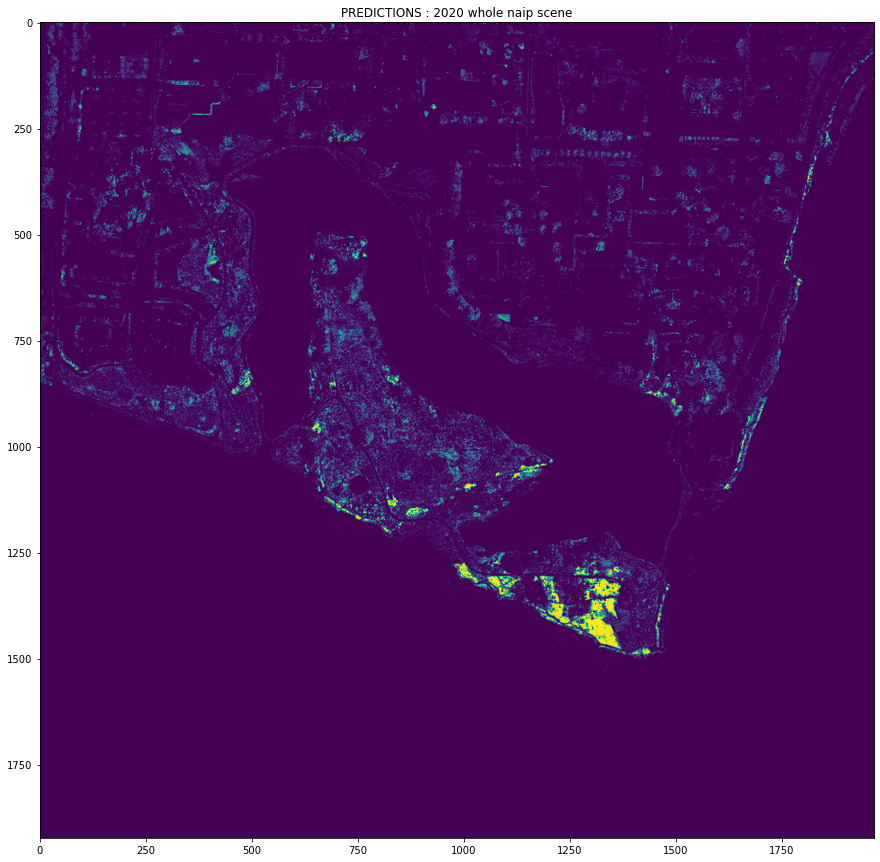

In [50]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 2020 whole naip scene")
ax.imshow(probs_image)
plt.show()